<a href="https://colab.research.google.com/github/amitdamri/FastAI-Repo/blob/main/VisionClassifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install -Uqq fastbook
!pip install gradio
!pip install nbdev

In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import gradio as gr
import nbdev

# Binary classification - Dog or Cat

Collect and transform data

In [ ]:
# download data - two directories images and annotations
path = untar_data(URLs.PETS)
print(path.ls())

[Path('/root/.fastai/data/oxford-iiit-pet/annotations'), Path('/root/.fastai/data/oxford-iiit-pet/dog-cat-classifier.pkl'), Path('/root/.fastai/data/oxford-iiit-pet/images'), Path('/root/.fastai/data/oxford-iiit-pet/models'), Path('/root/.fastai/data/oxford-iiit-pet/breeds-classifier.pkl')]


In [ ]:
# get the images only
files = get_image_files(path/'images')
print(len(files))

7390


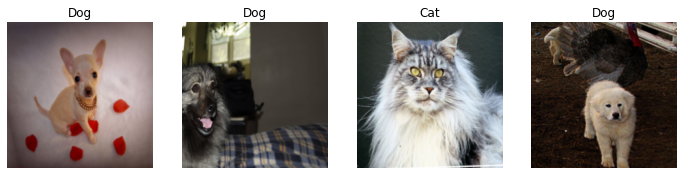

In [ ]:
# create a data loader to split the data into train and validation and transform
def label_func(f): return 'Cat' if f[0].isupper() else 'Dog'

dls = ImageDataLoaders.from_name_func(path, 
                                      files, 
                                      label_func, 
                                      item_tfms = RandomResizedCrop(224, min_scale = 0.75),
                                      batch_tfms = aug_transforms())
dls.show_batch(max_n = 4, nrows = 1)

Train and fine tune the model

In [ ]:
# Train and fine tune
learner = vision_learner(dls, resnet34, metrics = accuracy)
learner.fine_tune(1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Interpretation

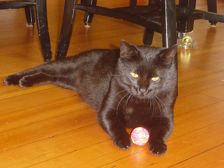

('Cat', TensorBase(0), TensorBase([1.0000e+00, 2.2894e-12]))
['Cat', 'Dog']


In [ ]:
img = PILImage.create(files[0])
display(img.to_thumb(224, 224))
print(learner.predict(files[0]))

# True for cat and False for dog
print(dls.vocab)

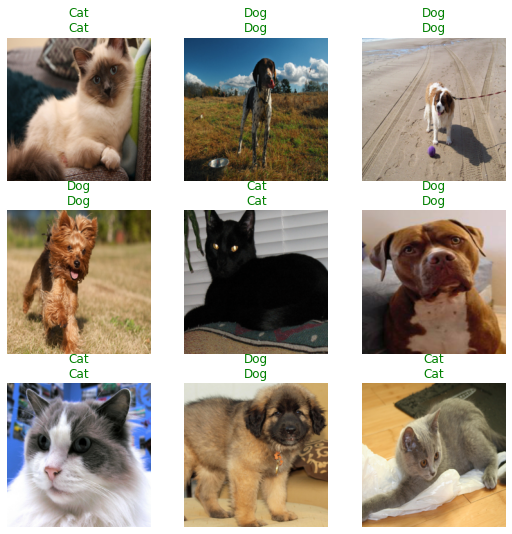

In [ ]:
learner.show_results()

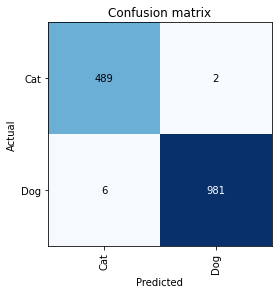

In [ ]:
interpt = ClassificationInterpretation.from_learner(learner)
interpt.plot_confusion_matrix()

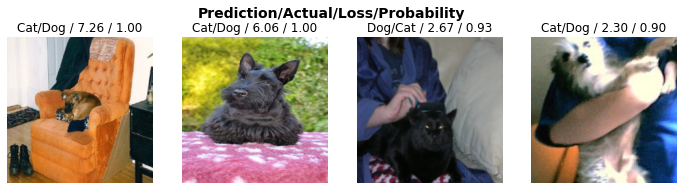

In [ ]:
interpt.plot_top_losses(4, nrows = 1)

In [ ]:
cleaner = ImageClassifierCleaner(learner)
cleaner

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
from google.colab import files as colab_files

learner.export('dog-cat-classifier.pkl')
colab_files.download(path/'dog-cat-classifier.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Multiclass classification - Breeds

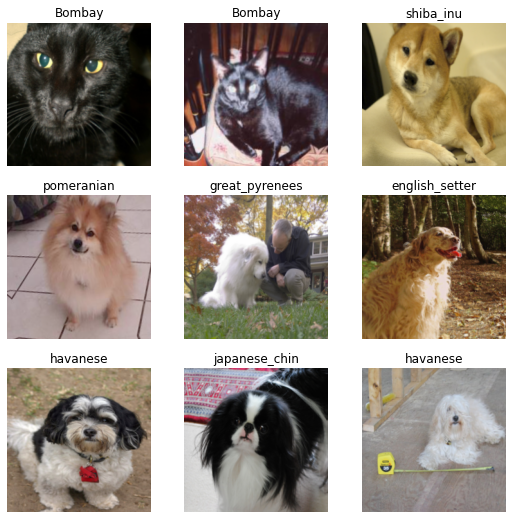

In [ ]:
pat = r'(.*)_\d+.jpg'
dls = ImageDataLoaders.from_name_re(path, 
                                    files, 
                                    pat, 
                                    item_tfms = RandomResizedCrop(224, min_scale = 0.75), 
                                    batch_tfms = aug_transforms(),
                                    splitter = RandomSplitter(valid_pct = 0.2, seed = 42))
dls.show_batch()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0014454397605732083)

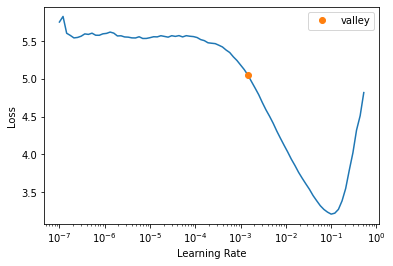

In [ ]:
learner = vision_learner(dls, resnet34, metrics = accuracy)
# learning rate finder
learner.lr_find()

In [ ]:
learner.fine_tune(2, 1e-3)

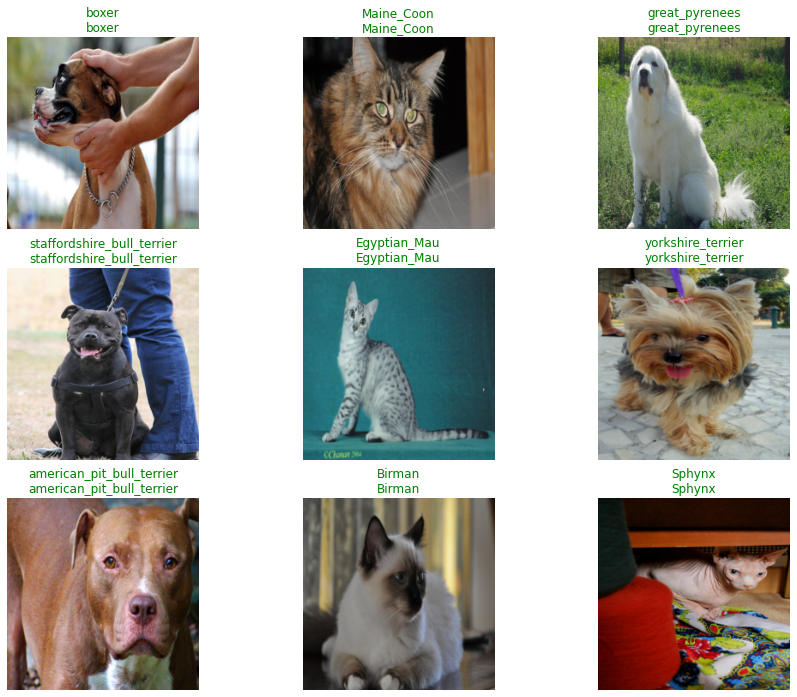

In [ ]:
learner.show_results(figsize = (15, 12))

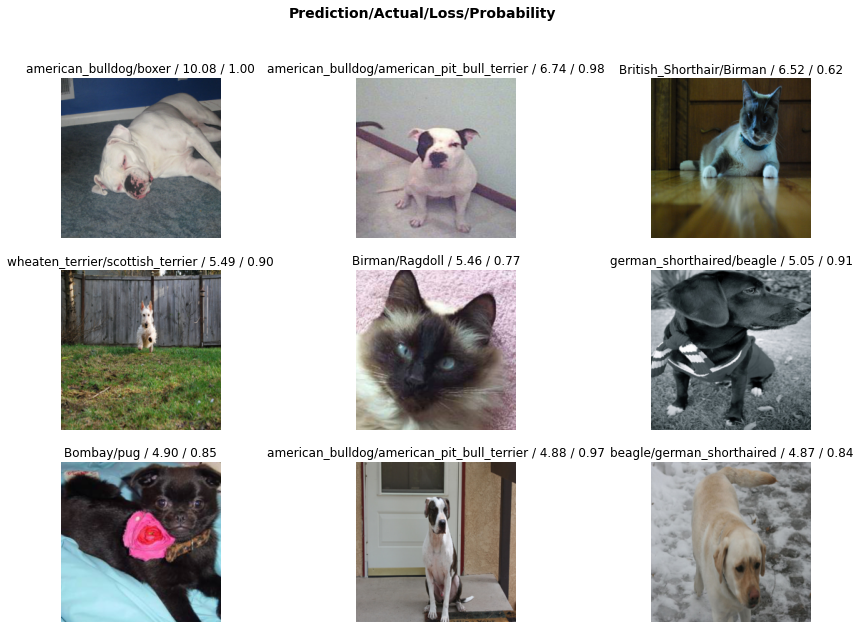

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, figsize = (15, 10))

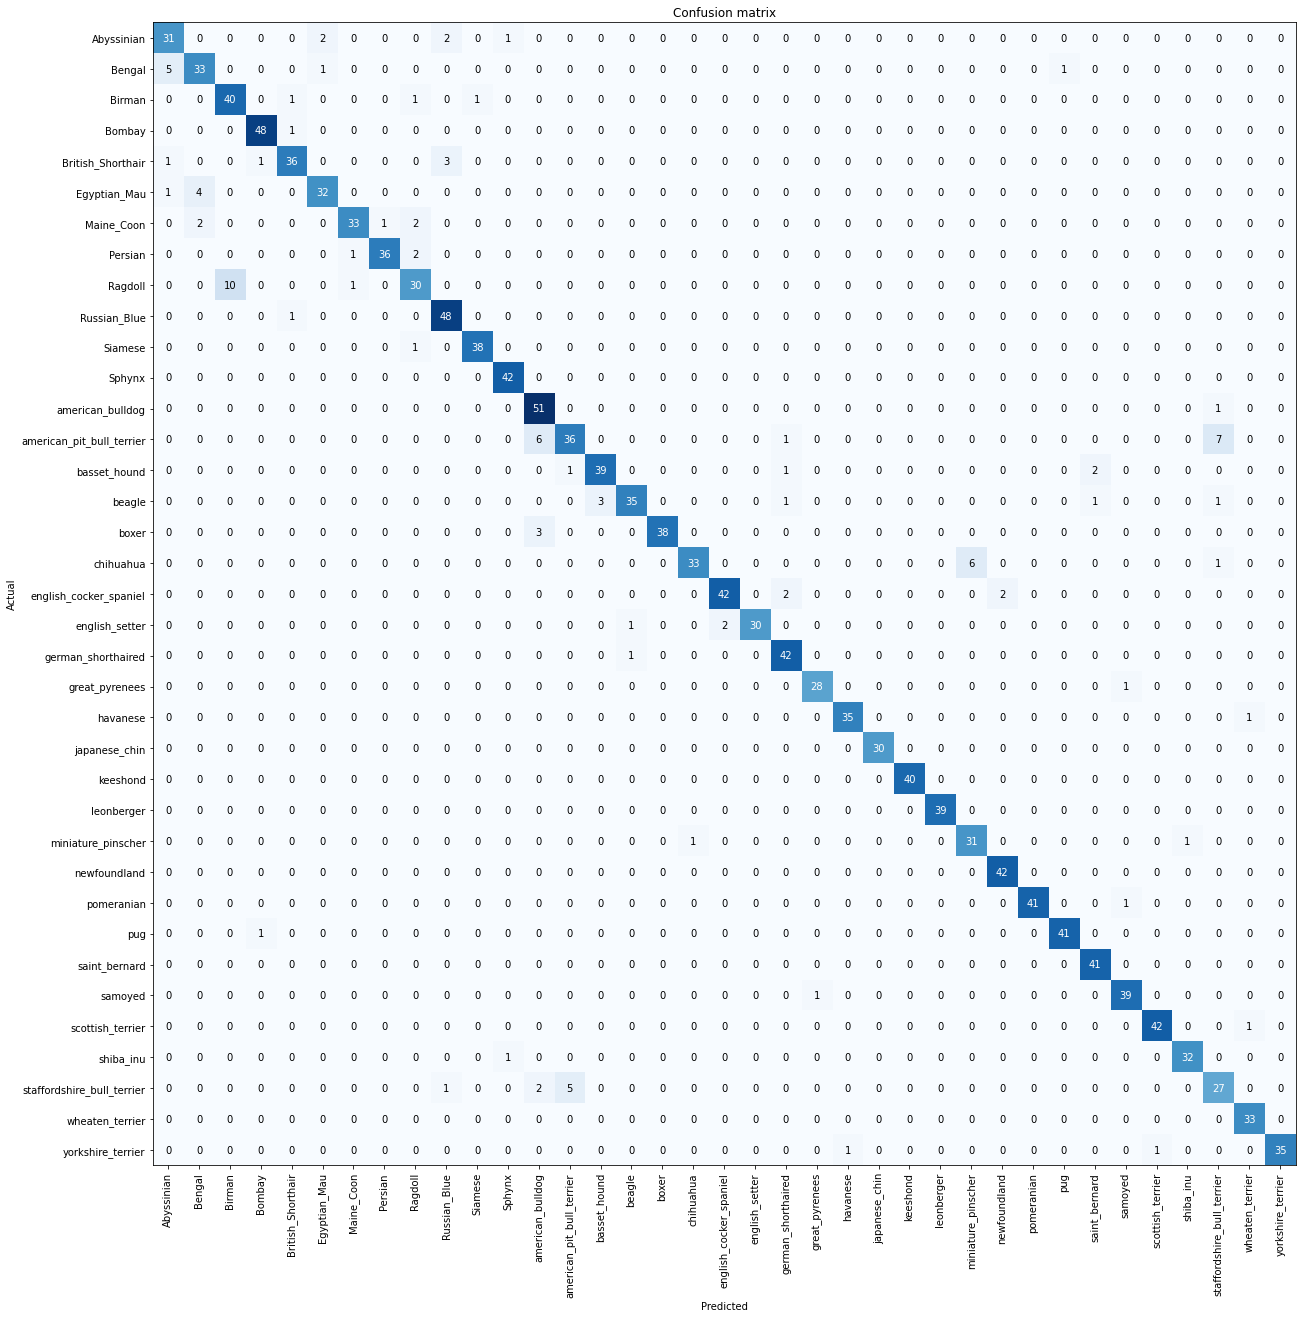

In [ ]:
interp.plot_confusion_matrix(figsize = (18, 20))

In [ ]:
learner.export('breeds-classifier.pkl')
colab_files.download(path/'breeds-classifier.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Single-label Classification with the data block API

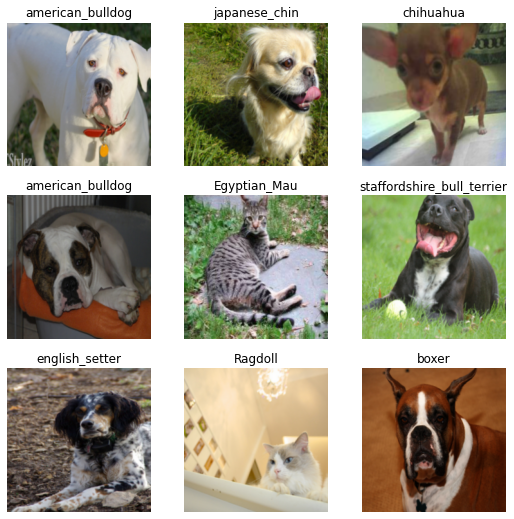

In [ ]:
pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = using_attr(RegexLabeller('^(.+)_\d+.jpg$'), 'name'),
    item_tfms = RandomResizedCrop(224, min_scale = 0.75),
    batch_tfms = aug_transforms(size = 224)
)

dls = pets.dataloaders(untar_data(URLs.PETS)/'images')
dls.show_batch()

# Multi-label classification

In [ ]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/train')]

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

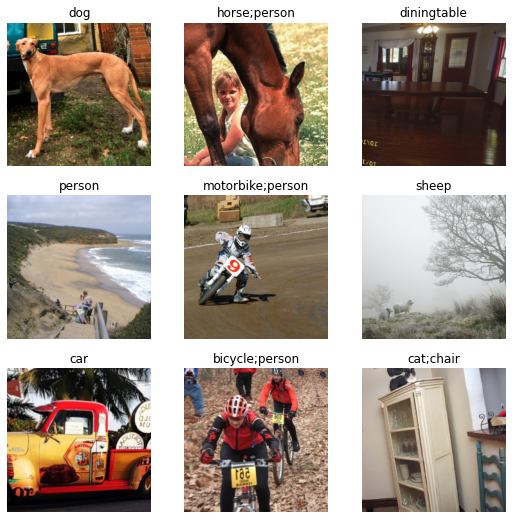

In [ ]:
dls = ImageDataLoaders.from_df(df, 
                               path, 
                               folder = 'train', 
                               valid_col = 'is_valid', 
                               label_delim = ' ', 
                               item_tfms = Resize(460), 
                               batch_tfms = aug_transforms(size=224)
                               )
dls.show_batch()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.002511886414140463)

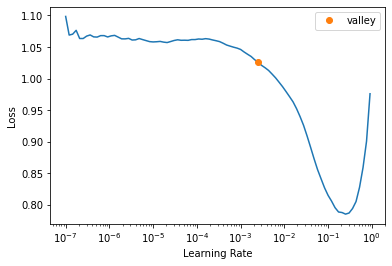

In [ ]:
f1_macro = F1ScoreMulti(thresh = 0.5, average = 'macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh = 0.5, average = 'samples')
f1_samples.name = 'F1(samples)'
learner = vision_learner(dls, resnet34, metrics = [partial(accuracy_multi, thresh = 0.5), f1_macro, f1_samples])
learner.lr_find()

In [ ]:
learner.fine_tune(2, 2e-2)

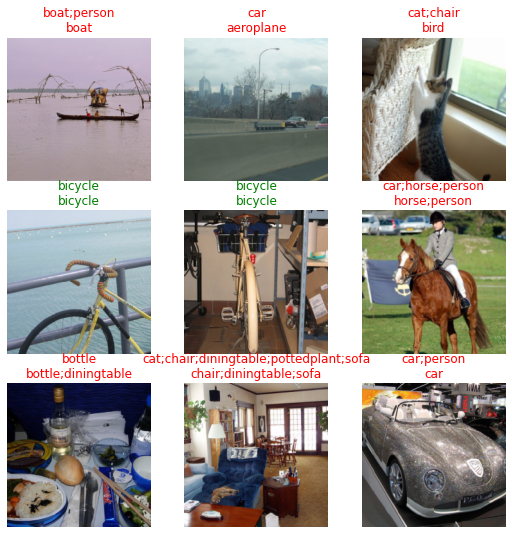

In [ ]:
learner.show_results()

In [ ]:
learner.predict(path/'train/000005.jpg')

((#2) ['chair','tvmonitor'],
 TensorBase([False, False, False, False, False, False, False, False,  True,
             False, False, False, False, False, False, False, False, False,
             False,  True]),
 TensorBase([3.1395e-04, 2.9984e-03, 4.3844e-04, 2.7754e-04, 4.1310e-03,
             2.4495e-04, 1.7821e-03, 5.8452e-02, 9.1042e-01, 7.0604e-04,
             2.5744e-01, 8.0931e-03, 3.8129e-04, 7.5508e-05, 1.5353e-02,
             3.1495e-02, 7.1274e-04, 4.3798e-01, 3.6824e-03, 6.0623e-01]))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


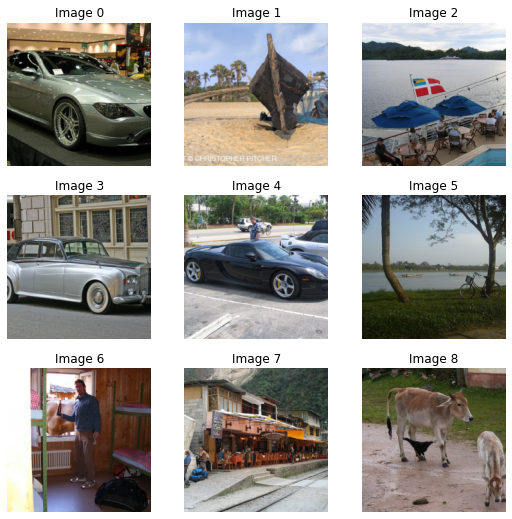

In [ ]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(9)

In [ ]:
learner.export('multi-label-classification.pkl')
colab_files.download(path/'multi-label-classification.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Multi label classification with DataBlock API

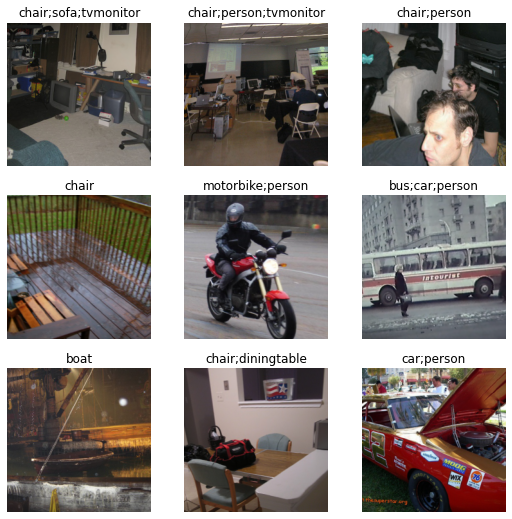

In [ ]:
pascal = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_x = ColReader('fname', pref = str(path/'train') + os.path.sep),
    get_y = ColReader('labels', label_delim = ' '),
    splitter = ColSplitter('is_valid'),
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size = 224)
)

dls = pascal.dataloaders(df)
dls.show_batch(max_n = 9)

# Segmentation

In [21]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/images')]

In [22]:
codes = np.loadtxt(path/'codes.txt', dtype = str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [23]:
files = get_image_files(path/'images')
files[0]

Path('/root/.fastai/data/camvid_tiny/images/0016E5_07973.png')

In [24]:
(path/'labels').ls()[0]

Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f01080_P.png')

In [25]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

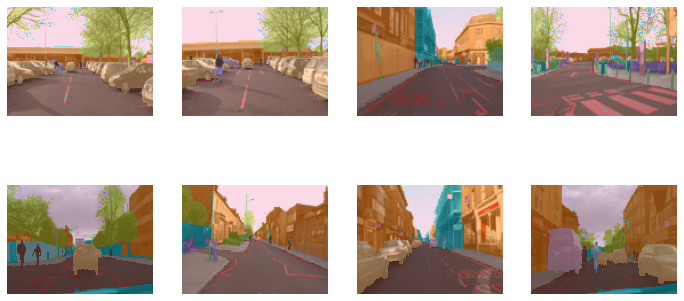

In [31]:
dls = SegmentationDataLoaders.from_label_func(
    path,
    bs = 8,
    fnames = files,
    label_func = label_func,
    codes = codes
)

dls.show_batch()

In [33]:
learner = unet_learner(dls, resnet18)
learner.fine_tune(20)

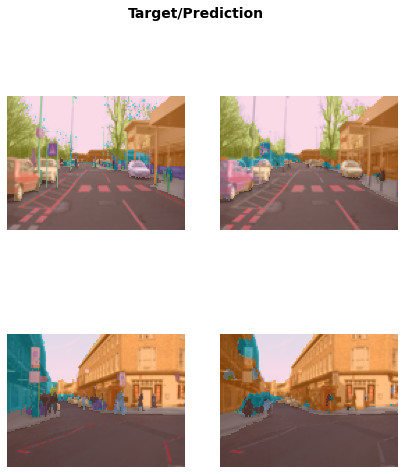

In [34]:
learner.show_results(max_n = 2, figsize = (7,8))

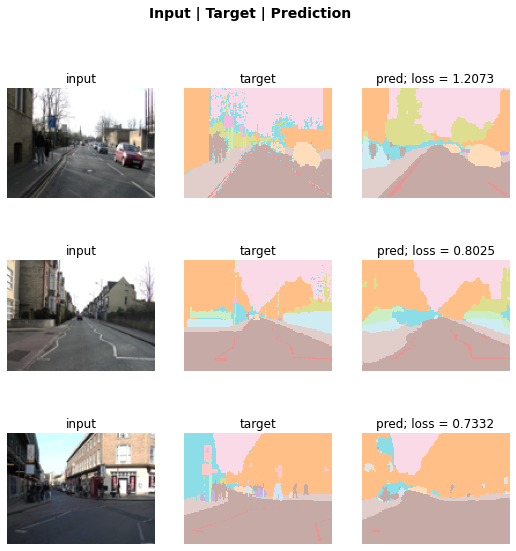

In [35]:
interp = SegmentationInterpretation.from_learner(learner)
interp.plot_top_losses(k = 3)

In [37]:
from google.colab import files as colab_files
learner.export('segmentation.pkl')
colab_files.download(path/'segmentation.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
import os
os.path.getsize(path/'segmentation.pkl')/ (1024 * 1024)

122.10962677001953

# Segmentation with DataBlock API

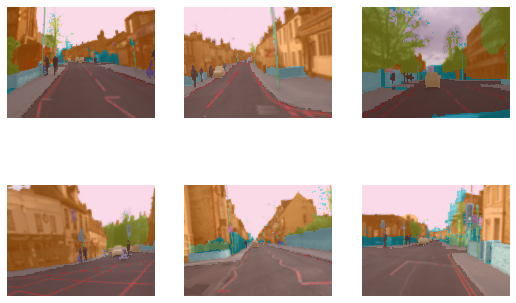

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))
dls = camvid.dataloaders(path/"images", path=path, bs=8)
dls.show_batch(max_n=6)

# Points

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/10'),Path('/root/.fastai/data/biwi_head_pose/13'),Path('/root/.fastai/data/biwi_head_pose/06'),Path('/root/.fastai/data/biwi_head_pose/01.obj'),Path('/root/.fastai/data/biwi_head_pose/22.obj'),Path('/root/.fastai/data/biwi_head_pose/io_sample.cpp'),Path('/root/.fastai/data/biwi_head_pose/readme.txt'),Path('/root/.fastai/data/biwi_head_pose/07'),Path('/root/.fastai/data/biwi_head_pose/14'),Path('/root/.fastai/data/biwi_head_pose/04')...]

In [4]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00088_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00364_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00320_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00287_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00245_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00170_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00401_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00094_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00322_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00108_rgb.jpg')...]

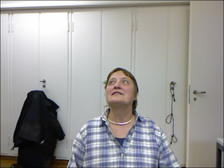

In [7]:
img = Image.open((path/'01').ls()[0])
img.to_thumb(224,224)

In [9]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/10/frame_00523_pose.txt')

(480, 640)


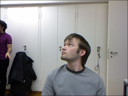

In [12]:
img = PILImage.create(img_files[0])
print(img.shape)
img.to_thumb(128,128)

In [13]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [14]:
get_ctr(img_files[0])

tensor([348.3530, 241.5356])

In [15]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

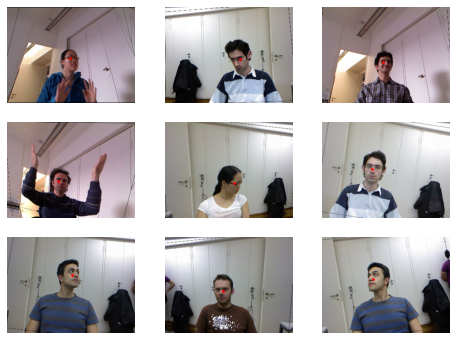

In [16]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(valley=0.00363078061491251)

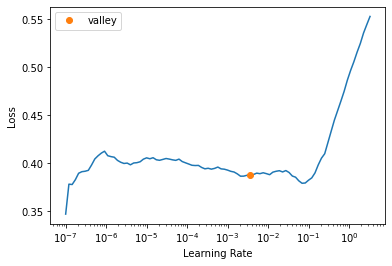

In [17]:
learner = vision_learner(dls, resnet18, y_range=(-1,1))
learner.lr_find()

In [19]:
learner.fine_tune(1, 5e-3)

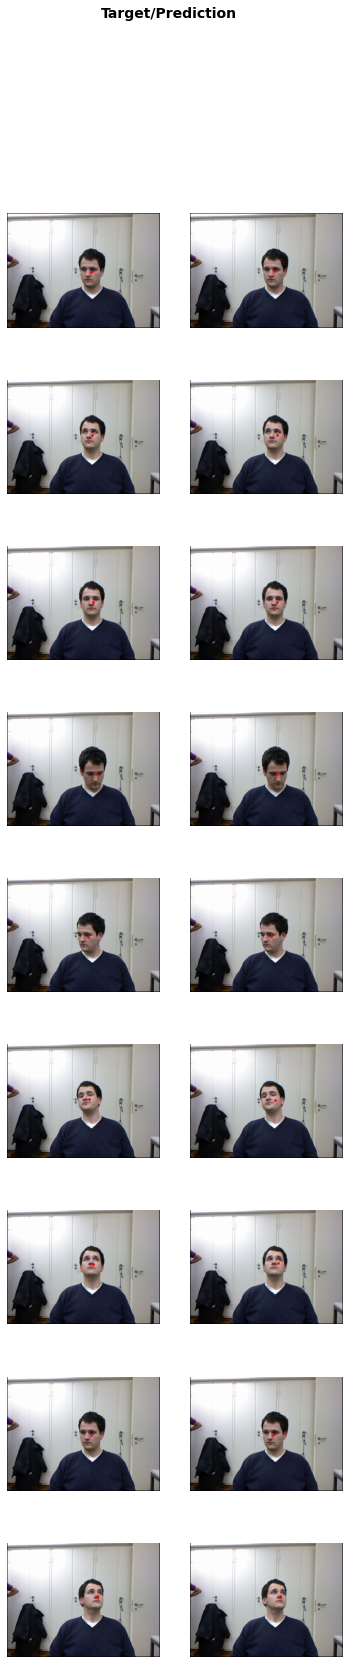

In [20]:
learner.show_results()